# Import Packages

In [ ]:
# Standard library
import os
from pathlib import Path

# Third-party libraries
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

from joblib import Parallel, delayed

from tqdm import tqdm
from tqdm.auto import tqdm as auto_tqdm

from qutip import (
    Bloch,
    Qobj,
    basis,
    coherent,
    destroy,
    expect,
    fidelity,
    mcsolve,
    mesolve,
    qeye,
    sigmax,
    sigmay,
    sigmaz,
    wigner,
)


In [2]:
# Directory for saving the plots and animation

project_root = Path.cwd()       # default: wherever you launched Jupyter
# if your notebook lives in a subfolder, uncomment the next line:
# project_root = project_root.parent

img_path = project_root / "images"
img_path.mkdir(exist_ok=True, parents=True)

print("Saving images to:", img_path)

Saving images to: /Users/EricSung/vs_code_projects/quantum_trajectories_project/images


In [ ]:


# # Base path
# my_path = "/Users/EricSung/vs_code_projects/quantum_trajectories_project"

# # Image path
# img_path = os.path.join(my_path, "images")


In [3]:
# Notify when a Jupyter Cell code execution is complete
os.system('osascript -e \'display notification "Code execution complete!" with title "Jupyter Notebook"\'')


0

# Open Quantum Systems

## Amplitude Damping for Qubit

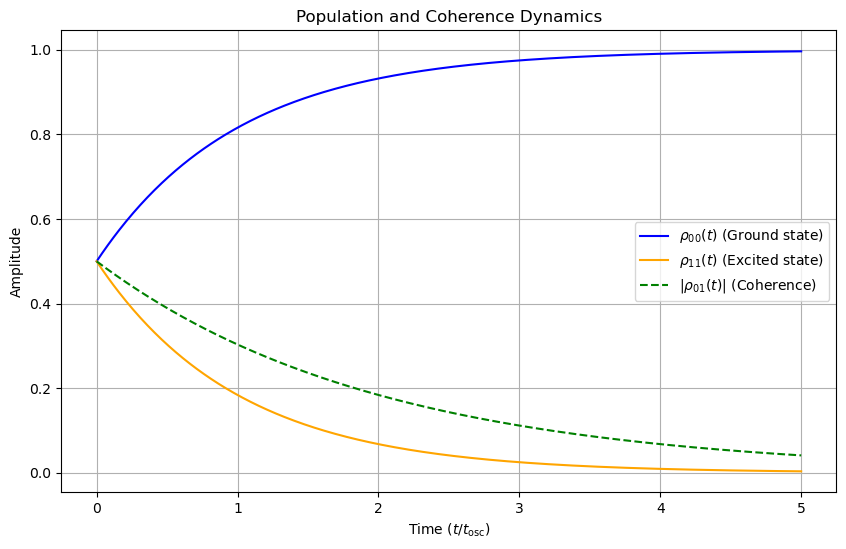

In [4]:
# Parameters matching the earlier code
gamma = 1.0  # Damping rate
tlist = np.linspace(0, 5, 500)  # Time range for simulation

# Initial state: Bloch vector aligned with (1, 1, 1), normalized
initial_state = (basis(2, 0) + basis(2, 1)).unit()

# Lindblad operator for amplitude damping
c_ops = [np.sqrt(gamma) * destroy(2)]

# Solve the Lindblad equation
result = mesolve(0 * sigmaz(), initial_state, tlist, c_ops, [])

# Extract populations and coherences
pop_0 = [expect(basis(2, 0) * basis(2, 0).dag(), state) for state in result.states]
pop_1 = [expect(basis(2, 1) * basis(2, 1).dag(), state) for state in result.states]
coherence = [abs(state.full()[0, 1]) for state in result.states]

# Plot populations and coherence
plt.figure(figsize=(10, 6))
plt.plot(tlist, pop_0, label=r"$\rho_{00}(t)$ (Ground state)", color="blue")
plt.plot(tlist, pop_1, label=r"$\rho_{11}(t)$ (Excited state)", color="orange")
plt.plot(tlist, coherence, label=r"$|\rho_{01}(t)|$ (Coherence)", color="green", linestyle="--")
plt.xlabel("Time $(t/t_{\\text{osc}})$")
plt.ylabel("Amplitude")
plt.title("Population and Coherence Dynamics")
plt.legend()
plt.grid()

# Save the plot
plt.savefig(os.path.join(img_path, 'population_coherence_dynamics_opti646.pdf'), dpi=300)

# Show the plot
plt.show()


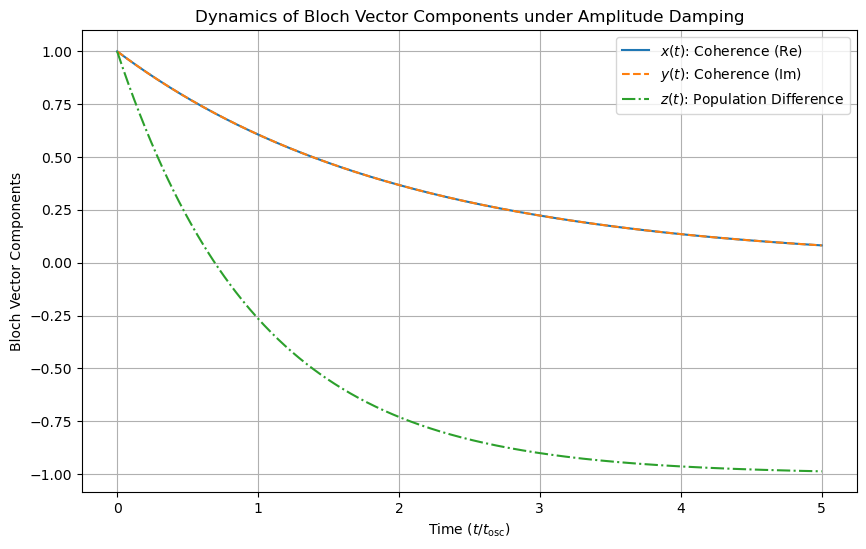

In [45]:
# Define parameters
gamma = 1.0  # Decay rate
t = np.linspace(0, 5, 500)  # Time points

# Initial conditions
x0 = 1.0
y0 = 1.0
z0 = 1.0

# Solutions for Bloch vector components
x = x0 * np.exp(-gamma * t / 2)
y = y0 * np.exp(-gamma * t / 2)
z = z0 * np.exp(-gamma * t) - (1 - np.exp(-gamma * t))

# Plot x(t), y(t), z(t)
plt.figure(figsize=(10, 6))

# Plot x(t)
plt.plot(t, x, label=r"$x(t)$: Coherence (Re)", linestyle="-")
# Plot y(t)
plt.plot(t, y, label=r"$y(t)$: Coherence (Im)", linestyle="--")
# Plot z(t)
plt.plot(t, z, label=r"$z(t)$: Population Difference", linestyle="-.")

# Customize the plot
plt.title("Dynamics of Bloch Vector Components under Amplitude Damping")
plt.xlabel("Time $(t/t_{\\text{osc}})$")
plt.ylabel("Bloch Vector Components")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(img_path, 'bloch_vector_components_opti646.pdf'), dpi=300)

# Show the plot
plt.show()

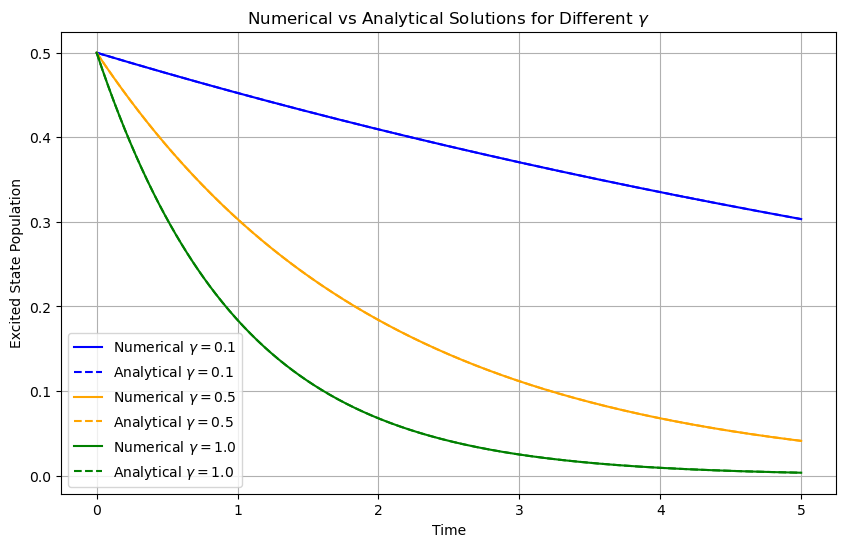

In [46]:
# Parameters for varying damping rates
gammas = [0.1, 0.5, 1.0]  # Different damping rates
colors = ["blue", "orange", "green"]

plt.figure(figsize=(10, 6))

# Solve for each gamma
for i, gamma in enumerate(gammas):
    c_ops = [np.sqrt(gamma) * destroy(2)]
    result = mesolve(0 * sigmaz(), initial_state, tlist, c_ops, [])
    pop_1_numerical = [expect(basis(2, 1) * basis(2, 1).dag(), state) for state in result.states]
    pop_1_analytical = [0.5 * np.exp(-gamma * t) for t in tlist]

    plt.plot(tlist, pop_1_numerical, label=rf"Numerical $\gamma = {gamma}$", linestyle="-", color=colors[i])
    plt.plot(tlist, pop_1_analytical, label=rf"Analytical $\gamma = {gamma}$", linestyle="--", color=colors[i])

# Customize the plot
plt.xlabel("Time")
plt.ylabel("Excited State Population")
plt.title(r"Numerical vs Analytical Solutions for Different $\gamma$")
plt.legend()
plt.grid()

# Save the plot
plt.savefig(os.path.join(img_path, 'different_gamma_comparisons.pdf'), dpi=300)

# Show the plot
plt.show()

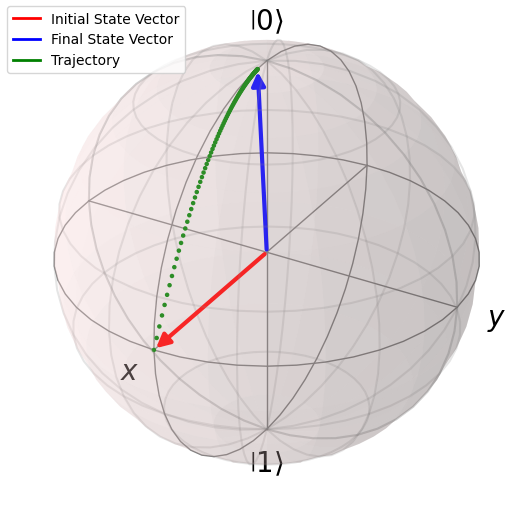

In [47]:
# Parameters
gamma = 1.0  # Damping rate
tlist = np.linspace(0, 5, 100)  # Time points for visualization

# Initial state: Bloch vector aligned with (1, 1, 1), normalized
initial_state = (basis(2, 0) + basis(2, 1)).unit()

# Collapse operator for amplitude damping
c_ops = [np.sqrt(gamma) * destroy(2)]

# Solve the master equation
result = mesolve(0 * sigmaz(), initial_state, tlist, c_ops, [])

# Extract Bloch vector components
x_vals = [expect(sigmax(), state) for state in result.states]
y_vals = [expect(sigmay(), state) for state in result.states]
z_vals = [expect(sigmaz(), state) for state in result.states]

# Create a Bloch sphere visualization
b = Bloch()
b.add_points([x_vals, y_vals, z_vals])  # Add trajectory points
b.add_vectors([x_vals[0], y_vals[0], z_vals[0]])  # Add initial state vector
b.add_vectors([x_vals[-1], y_vals[-1], z_vals[-1]])  # Add final state vector

# Customize the Bloch sphere
b.vector_color = ['red', 'blue']  # Colors for initial and final vectors
b.point_color = 'green'  # Color for trajectory points
b.point_marker = 'o'  # Marker style for points
b.point_size = [5] * len(x_vals)  # Size of trajectory points

# Render the Bloch sphere
b.render()

# Add a legend manually
fig = b.fig
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='Initial State Vector'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Final State Vector'),
    plt.Line2D([0], [0], color='green', linestyle='-', lw=2, label='Trajectory'),
]
# Add legend to the figure
fig.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Save the Bloch sphere visualization as a PDF
b.fig.savefig(os.path.join(img_path, 'bloch_sphere_dynamics_opti646.pdf'), dpi=300)

# Show the Bloch sphere
b.show()


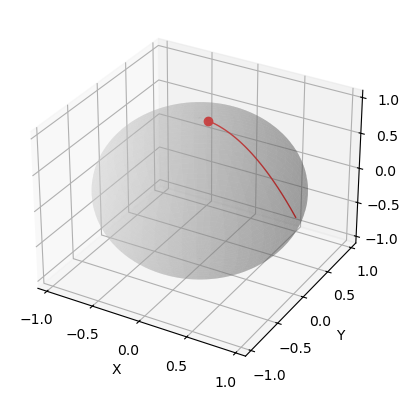

In [48]:
# Parameters
gamma = 1.0  # Damping rate
tlist = np.linspace(0, 5, 50)  # Time points for visualization

# Initial state: Bloch vector aligned with (1, 1, 1), normalized
initial_state = (basis(2, 0) + basis(2, 1)).unit()

# Collapse operator for amplitude damping
c_ops = [np.sqrt(gamma) * destroy(2)]

# Solve the master equation
result = mesolve(0 * sigmaz(), initial_state, tlist, c_ops, [])

# Extract Bloch vector components
x_vals = [expect(sigmax(), state) for state in result.states]
y_vals = [expect(sigmay(), state) for state in result.states]
z_vals = [expect(sigmaz(), state) for state in result.states]

# Create a Matplotlib 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set up the Bloch sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.3, linewidth=0)

# Initialize the plot
point, = ax.plot([], [], [], 'ro', markersize=6)
trajectory, = ax.plot([], [], [], 'r-', lw=1)

# Set axis limits
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_zlim([-1.1, 1.1])

# Axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Update function for animation
def update(num):
    point.set_data([x_vals[num]], [y_vals[num]])
    point.set_3d_properties([z_vals[num]])
    trajectory.set_data(x_vals[:num+1], y_vals[:num+1])
    trajectory.set_3d_properties(z_vals[:num+1])
    return point, trajectory

# Create the animation
ani = FuncAnimation(fig, update, frames=len(tlist), interval=100, blit=True)

# Save the animation as a GIF
ani.save(os.path.join(img_path, 'bloch_sphere_dynamics_opti646.gif'), writer='pillow', fps=10)

# Show the plot
plt.show()


# Quantum Trajectories

## Schrödinger Cat States

We will be measuring

\begin{align}
\langle \mathcal{P} \rangle= \langle e^{i\pi a^{\dagger} a} \rangle, \quad \mathcal{C} = | \langle a \rangle |, \quad \langle N \rangle = \langle a^{\dagger} a \rangle,
\end{align}

which are the expected parity, coherence, and photon number, respectively. 

## Lindblad Dynamics

In [ ]:


# Progress bar customization
options = {"progress_bar": "tqdm"}

# Parameters
alpha = 2.0             # Coherent state amplitude
kappa = 0.1             # Photon loss rate
t_max = 10.0             # Maximum simulation time
n_steps = 1000          # Number of time steps
dim = 20                # Hilbert space dimension
dt = t_max / n_steps    # Time step size
tlist = np.linspace(0, t_max, n_steps)

# Initial cat state
coherent_plus = coherent(dim, alpha) + coherent(dim, -alpha)
psi_cat = coherent_plus.unit()

# Operators
a = destroy(dim)
Delta = 1.00  # Detuning (set to zero if not applicable)
H = Delta * a.dag() * a  # Example Hamiltonian
L1 = np.sqrt(kappa / 2) * (a + 1j * alpha)
L2 = 1j * np.sqrt(kappa / 2) * (a - 1j * alpha)
c_ops = [L1, L2]

# Solve Lindblad master equation
lindblad_result_comp = mesolve(H, psi_cat, tlist, c_ops=c_ops,)

# Compute Wigner function for the initial state
lindblad_W = wigner(lindblad_result_comp.states[0], x, y)

# Observables
# 1. Parity operator
parity_op = sum([(-1)**n * basis(dim, n) * basis(dim, n).dag() for n in range(dim)])
lindblad_parity_comp = [expect(parity_op, rho) for rho in lindblad_result_comp.states]

# 2. Photon number expectation value
photon_number_op = a.dag() * a
lindblad_photon_number_comp = [expect(photon_number_op, rho) for rho in lindblad_result_comp.states]

# 3. Coherence operator (off-diagonal element between |alpha> and |-alpha>)
coherence_op = coherent(dim, alpha) * coherent(dim, -alpha).dag()
lindblad_coherence_comp = [np.real(rho.overlap(coherence_op)) for rho in lindblad_result_comp.states]

# 4. Wigner function snapshots at selected times
snapshots_times = [0, 5, 10]  # Time points for snapshots
snapshots_indices = [np.argmin(np.abs(tlist - t)) for t in snapshots_times]
x = np.linspace(-4, 4, 200)
y = np.linspace(-4, 4, 200)
X, Y = np.meshgrid(x, y)
wigner_snapshots = [wigner(lindblad_result_comp.states[idx], x, y) for idx in snapshots_indices]


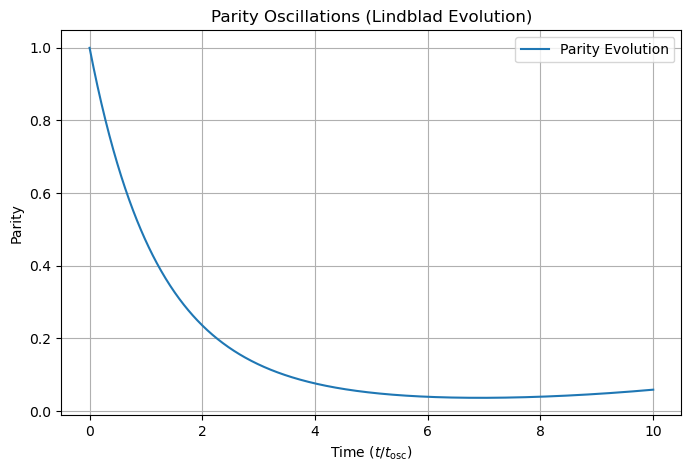

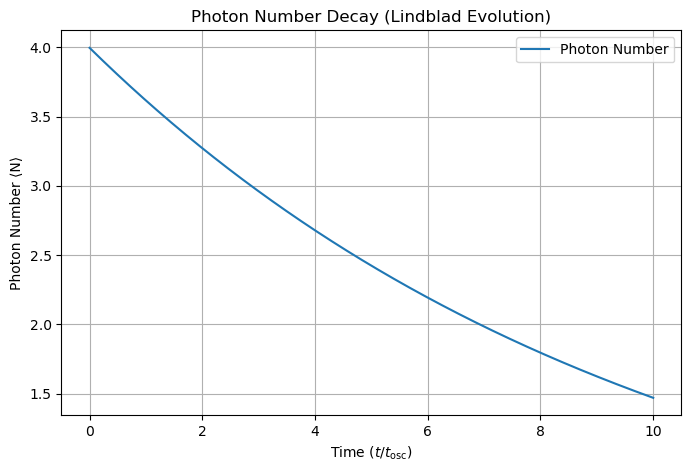

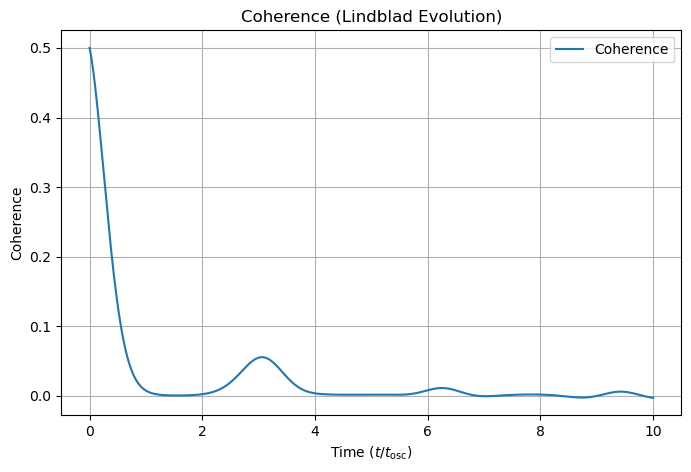

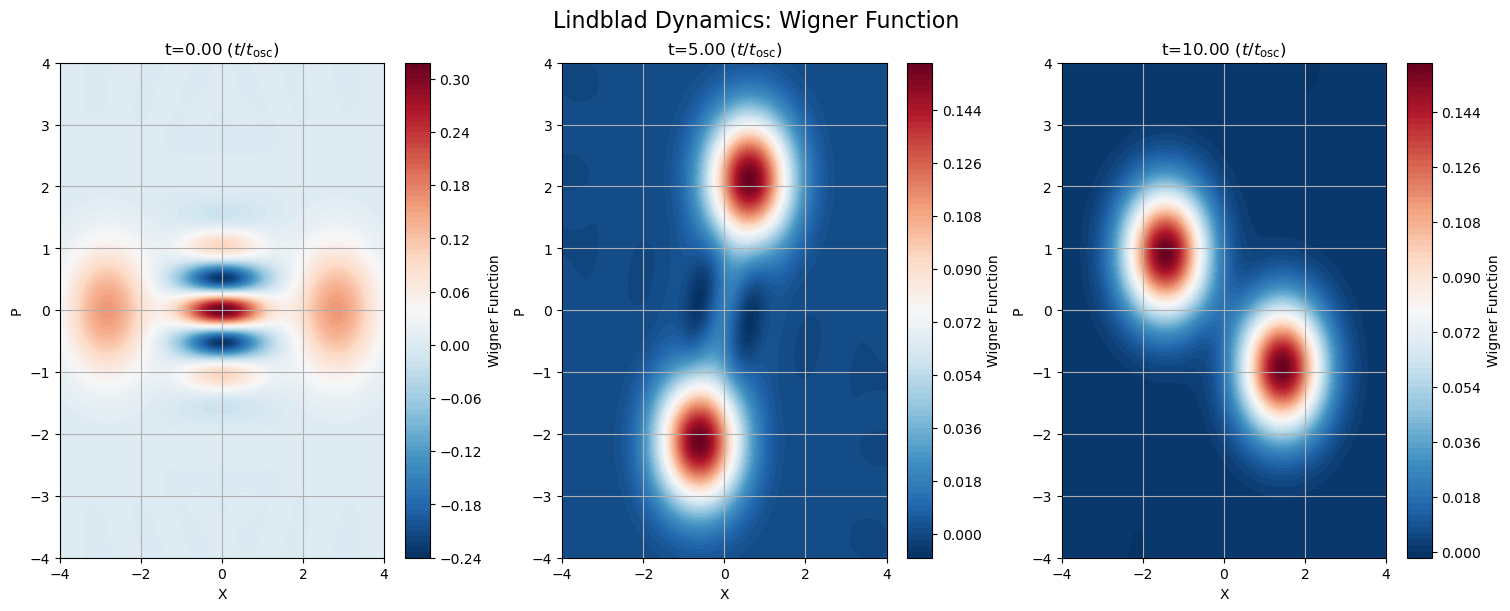

In [76]:
# Save Parity Evolution Plot
plt.figure(figsize=(8, 5))
plt.plot(tlist, lindblad_parity_comp, label="Parity Evolution")
plt.xlabel("Time $(t/t_{\\text{osc}})$")
plt.ylabel("Parity")
plt.title("Parity Oscillations (Lindblad Evolution)")
plt.legend()
plt.grid()

# Save the plot
plt.savefig(os.path.join(img_path, 'parity_evolution_lindblad_opti646.pdf'), dpi=300)

# Show the plot
plt.show()

# Plotting Photon Number
plt.figure(figsize=(8, 5))
plt.plot(tlist, lindblad_photon_number_comp, label="Photon Number")
plt.xlabel("Time $(t/t_{\\text{osc}})$")
plt.ylabel("Photon Number ⟨N⟩")
plt.title("Photon Number Decay (Lindblad Evolution)")
plt.legend()
plt.grid()

# Save the plot
plt.savefig(os.path.join(img_path, 'photon_number_lindblad_opti646.pdf'), dpi=300)

# Show the plot
plt.show()

# Plotting Coherence
plt.figure(figsize=(8, 5))
plt.plot(tlist, lindblad_coherence_comp, label="Coherence")
plt.xlabel("Time $(t/t_{\\text{osc}})$")
plt.ylabel("Coherence")
plt.title("Coherence (Lindblad Evolution)")
plt.legend()
plt.grid()

# Save the plot
plt.savefig(os.path.join(img_path, 'coherence_lindblad_opti646.pdf'), dpi=300)

# Show the plot
plt.show()

# Save Wigner Function Snapshots in a Single Side-by-Side Plot
fig, axes = plt.subplots(1, len(snapshots_times), figsize=(15, 6), constrained_layout=True)

for ax, t, wigner_data in zip(axes, snapshots_times, wigner_snapshots):
    contour = ax.contourf(X, Y, wigner_data, 100, cmap="RdBu_r")
    fig.colorbar(contour, ax=ax, label="Wigner Function")
    ax.set_title(f"t={t:.2f} $(t/t_\\text{{osc}})$")
    ax.set_xlabel("X")
    ax.set_ylabel("P")
    ax.grid()

fig.suptitle("Lindblad Dynamics: Wigner Function", fontsize=16)
plt.savefig(os.path.join(img_path, 'wigner_snapshots_lindblad_opti646.pdf'), dpi=300)
plt.show()



In [77]:
# Create a figure for the animation
fig, ax = plt.subplots(figsize=(5,4))

# # Compute Wigner function for the initial state and set up the plot
# W = wigner(result.states[0], x, y)
cax = ax.pcolormesh(X, Y, lindblad_W, shading='auto', cmap='RdBu_r', vmin=-abs(lindblad_W).max(), vmax=abs(lindblad_W).max())
ax.set_xlabel('x')
ax.set_ylabel('p')
ax.set_title('Wigner Function at t=0 $(t/t_\\text{{osc}})$')
fig.colorbar(cax, ax=ax)

# Update function for animation
def update(frame):
    state = lindblad_result_comp.states[frame]
    W = wigner(state, x, y)
    cax.set_array(W.ravel())
    cax.set_clim(-abs(W).max(), abs(W).max())  # Adjust color limits if needed
    ax.set_title(f"(Lindblad) Wigner Function at t={tlist[frame]:.2f} $(t/t_\\text{{osc}})$")
    return [cax]

# Create animation
anim = FuncAnimation(fig, update, frames=len(tlist), blit=False, repeat=False)

# Save animation as GIF using pillow writer
anim.save(os.path.join(img_path, 'wigner_animation_lindblad_opti646.gif'), writer='pillow', fps=5)
plt.close(fig)

In [78]:
# Notify when a Jupyter Cell code execution is complete
os.system('osascript -e \'display notification "Code execution complete!" with title "Jupyter Notebook"\'')


0

## Poisson Unraveling

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

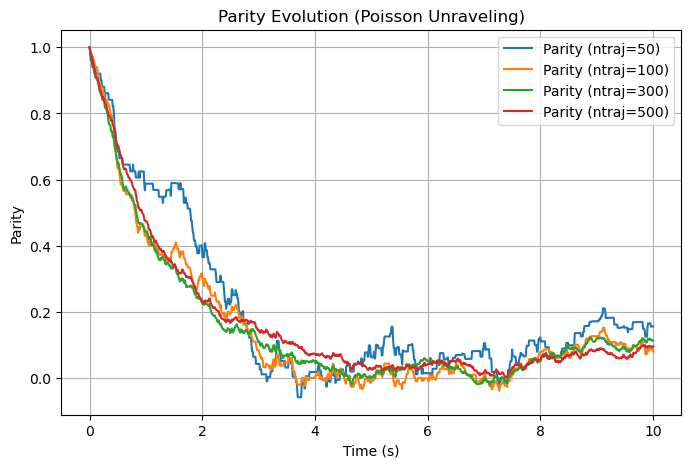

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

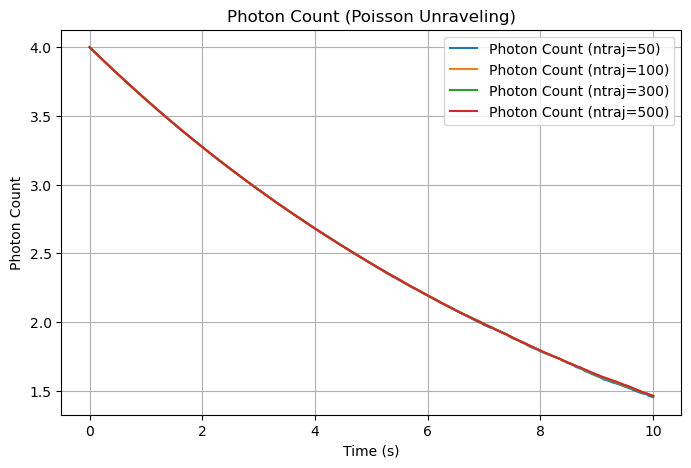

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/EricSung/opt/anaconda3/envs/open_quantum_systems_env/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/EricSung/opt/anaconda3/envs/open_quantum_systems_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

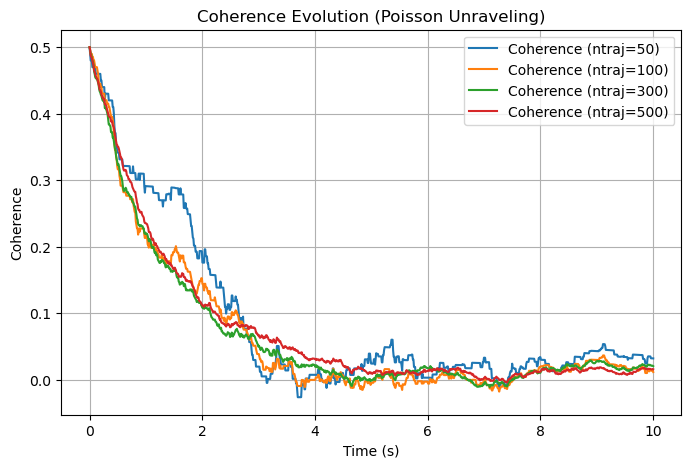

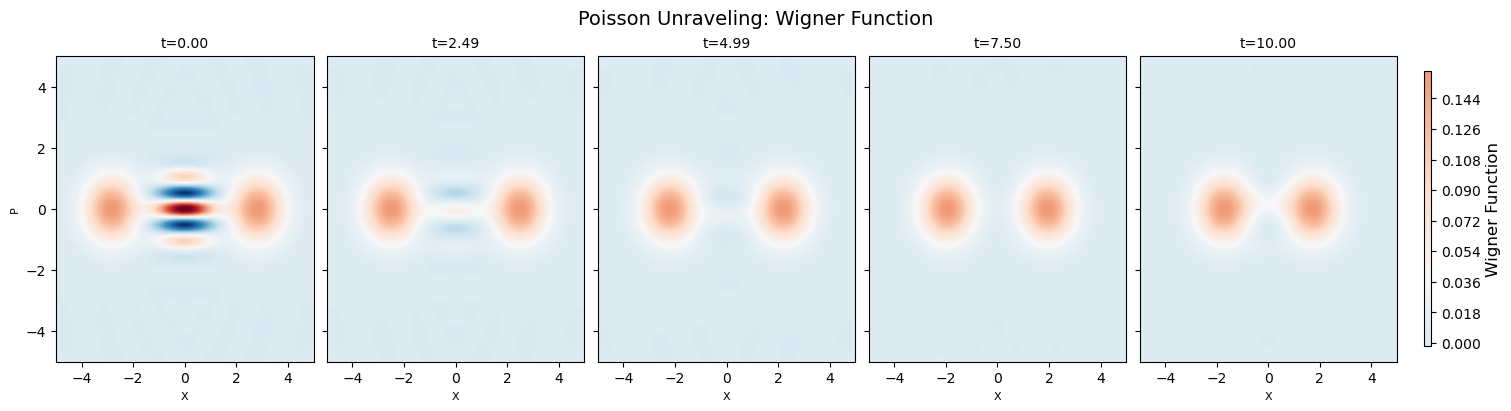

In [ ]:
# Progress bar customization
options = {"progress_bar": "tqdm"}

# Parameters
alpha = 2.0             # Coherent state amplitude
kappa = 0.1             # Photon loss rate
t_max = 10.0             # Maximum simulation time
n_steps = 1000          # Number of time steps
dim = 20                # Hilbert space dimension
dt = t_max / n_steps    # Time step size
tlist = np.linspace(0, t_max, n_steps)
poisson_seed = 42

# Initial cat state
coherent_plus = coherent(dim, alpha) + coherent(dim, -alpha)
psi_cat = coherent_plus.unit()

# Operators
a = destroy(dim)
Delta = 1.00  # Detuning (set to zero if not applicable)
H = Delta * a.dag() * a  # Example Hamiltonian
L1 = np.sqrt(kappa / 2) * (a + 1j * alpha)
L2 = 1j * np.sqrt(kappa / 2) * (a - 1j * alpha)
c_ops = [L1, L2]

# Parity operator
parity_op = sum(
    [(-1) ** n * basis(dim, n) * basis(dim, n).dag() for n in range(dim)]
)

# Photon number operator
photon_number_op = a.dag() * a

# Coherence operator (off-diagonal element between |alpha> and |-alpha>)
coherence_op = coherent(dim, alpha) * coherent(dim, -alpha).dag()

# Different ntraj values to compare
poisson_ntraj_list = [50, 100, 300, 500]
# poisson_ntraj_list = [5]

# Parity Evolution
plt.figure(figsize=(8, 5))

# Run Monte Carlo simulations and plot parity evolution
poisson_result = None  # Placeholder to store the last mcsolve result
for ntraj in poisson_ntraj_list:
    # Run Monte Carlo simulation
    poisson_mc_result = mcsolve(H, psi_cat, tlist, c_ops=c_ops, ntraj=ntraj, seeds=poisson_seed, options=options)
    poisson_result = poisson_mc_result  # Save the last result for Wigner snapshots
    # Compute parity expectation values
    poisson_parity = expect(parity_op, poisson_mc_result.states)
    # Plot the result
    plt.plot(tlist, poisson_parity, label=f"Parity (ntraj={ntraj})")

# Customize the plot
plt.xlabel("Time $(t/t_\\text{{osc}})$")
plt.ylabel("Parity")
plt.title("Parity Evolution (Poisson Unraveling)")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(img_path, 'parity_evolution_poisson_multi_math599.pdf'), dpi=300)

# Show the plot
plt.show()

# Photon Number Evolution
plt.figure(figsize=(8, 5))

for ntraj in poisson_ntraj_list:
    # Run Monte Carlo simulation (reuse poisson_mc_result)
    poisson_mc_result = mcsolve(H, psi_cat, tlist, c_ops=c_ops, ntraj=ntraj, seeds=poisson_seed, options=options)
    # Compute photon number expectation values
    poisson_photon_count = expect(photon_number_op, poisson_mc_result.states)
    # Plot the result
    plt.plot(tlist, poisson_photon_count, label=f"Photon Count (ntraj={ntraj})")

# Customize the plot
plt.xlabel("Time $(t/t_\\text{{osc}})$")
plt.ylabel("Photon Count")
plt.title("Photon Count (Poisson Unraveling)")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(img_path, 'photon_count_poisson_multi_math599.pdf'), dpi=300)

# Show the plot
plt.show()

# Coherence Evolution
plt.figure(figsize=(8, 5))

for ntraj in poisson_ntraj_list:
    # Run Monte Carlo simulation (reuse poisson_mc_result)
    poisson_mc_result = mcsolve(H, psi_cat, tlist, c_ops=c_ops, ntraj=ntraj, seeds=poisson_seed, options=options)
    # Compute coherence expectation values
    poisson_coherence_multi = expect(coherence_op, poisson_mc_result.states)
    # Plot the result
    plt.plot(tlist, poisson_coherence_multi, label=f"Coherence (ntraj={ntraj})")

# Customize the plot
plt.xlabel("Time $(t/t_\\text{{osc}})$")
plt.ylabel("Coherence")
plt.title("Coherence Evolution (Poisson Unraveling)")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(img_path, 'coherence_poisson_multi_math599.pdf'), dpi=300)

# Show the plot
plt.show()

# Function to plot Wigner snapshots
def save_wigner_snapshots(
    states, title, times, n_steps, x_range=5, y_range=5, filename="wigner_snapshots"
):
    x = np.linspace(-x_range, x_range, 200)
    y = np.linspace(-y_range, y_range, 200)
    X, Y = np.meshgrid(x, y)

    # Compute global min and max across all states for consistent color scale
    global_min, global_max = float("inf"), float("-inf")
    for state in states:
        W = wigner(state, x, y)
        global_min = min(global_min, W.min())
        global_max = max(global_max, W.max())

    # Select 5 evenly spaced snapshots
    snapshot_indices = np.linspace(0, len(states) - 1, 5, dtype=int)

    # Create the figure and axes with constrained layout
    fig, axes = plt.subplots(
        1, 5, figsize=(15, 4), sharey=True, constrained_layout=True
    )

    # Plot each snapshot
    for i, idx in enumerate(snapshot_indices):
        state = states[idx]
        W = wigner(state, x, y)
        ax = axes[i]
        im = ax.contourf(
            X, Y, W, 100, cmap="RdBu_r", vmin=global_min, vmax=global_max
        )
        ax.set_title(f"t={times[idx]:.2f} $(t/t_\\text{{osc}})$", fontsize=10)
        ax.set_xlabel("X", fontsize=8)
        if i == 0:
            ax.set_ylabel("P", fontsize=8)

    # Add a single color bar for the entire figure
    cbar = fig.colorbar(
        im, ax=axes, location="right", aspect=40, shrink=0.9, pad=0.02
    )
    cbar.set_label("Wigner Function", fontsize=12)

    # Save the figure in tight layout
    fig.suptitle(title, fontsize=14)
    plt.savefig(os.path.join(img_path, f'{filename}.pdf'), format="pdf", bbox_inches="tight", dpi=300)
    plt.show()
    

# Wigner snapshots
# snapshot_times = np.linspace(0, len(states) - 1, 5, dtype=int)  # The times at which you want Wigner snapshots
# Save Poisson unraveling snapshots
save_wigner_snapshots(
    poisson_result.states,
    "Poisson Unraveling: Wigner Function",
    tlist,
    n_steps,
    filename="poisson_wigner_multi_math599",
)


In [ ]:
# Progress bar customization
options = {"map": "parallel", "progress_bar": "tqdm"}

# Parameters
alpha = 2.0             # Coherent state amplitude
kappa = 0.1             # Photon loss rate
t_max = 10.0             # Maximum simulation time
n_steps = 1000          # Number of time steps
dim = 20                # Hilbert space dimension
dt = t_max / n_steps    # Time step size
tlist = np.linspace(0, t_max, n_steps)
poisson_seed = 42

# Initial cat state
coherent_plus = coherent(dim, alpha) + coherent(dim, -alpha)
psi_cat = coherent_plus.unit()

# Operators
a = destroy(dim)
Delta = 1.00  # Detuning (set to zero if not applicable)
H = Delta * a.dag() * a  # Example Hamiltonian
L1 = np.sqrt(kappa / 2) * (a + 1j * alpha)
L2 = 1j * np.sqrt(kappa / 2) * (a - 1j * alpha)
c_ops = [L1, L2]

# Parity operator
parity_op = sum(
    [(-1) ** n * basis(dim, n) * basis(dim, n).dag() for n in range(dim)]
)

# Photon number operator
photon_number_op = a.dag() * a

# Coherence operator (off-diagonal element between |alpha> and |-alpha>)
coherence_op = coherent(dim, alpha) * coherent(dim, -alpha).dag()

# Different ntraj values to compare
poisson_ntraj_list = [50, 100, 300, 500]
# poisson_ntraj_list = [5] # Smaller ntraj for testin

# Store Monte Carlo results once
poisson_results = {ntraj: mcsolve(H, psi_cat, tlist, c_ops=c_ops, ntraj=ntraj, seeds=poisson_seed, options=options) 
                   for ntraj in poisson_ntraj_list
                   }

# Compute expectation values once
poisson_parity_results = {ntraj: expect(parity_op, poisson_results[ntraj].states) for ntraj in poisson_ntraj_list}
poisson_photon_results = {ntraj: expect(photon_number_op, poisson_results[ntraj].states) for ntraj in poisson_ntraj_list}
poisson_coherence_results = {ntraj: expect(coherence_op, poisson_results[ntraj].states) for ntraj in poisson_ntraj_list}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

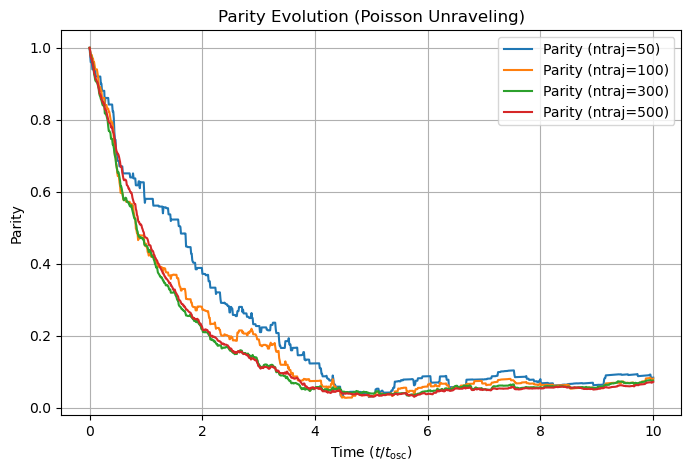

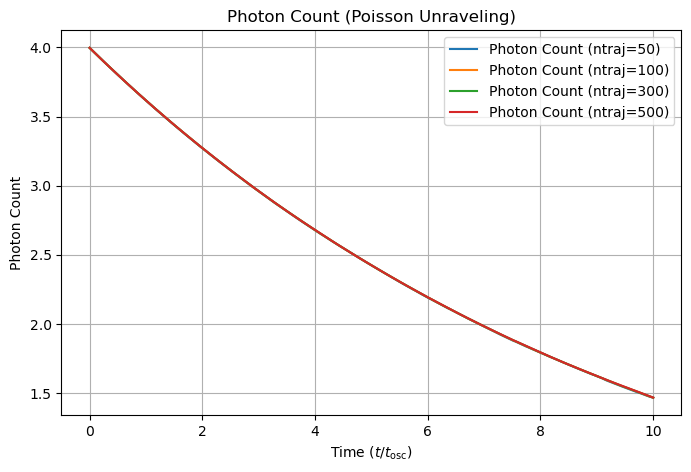

/Users/EricSung/opt/anaconda3/envs/open_quantum_systems_env/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/EricSung/opt/anaconda3/envs/open_quantum_systems_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


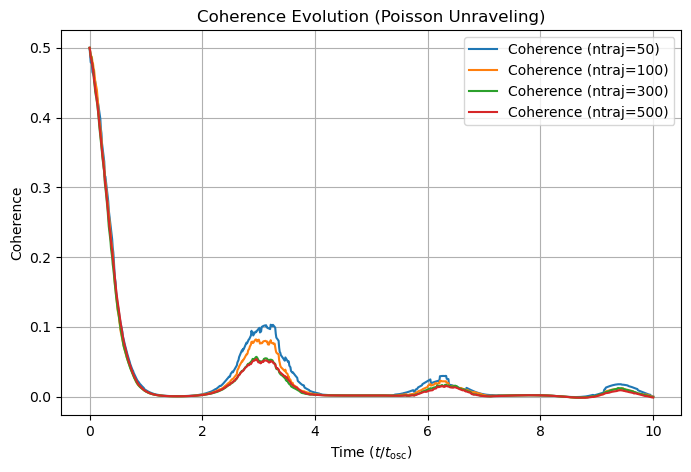

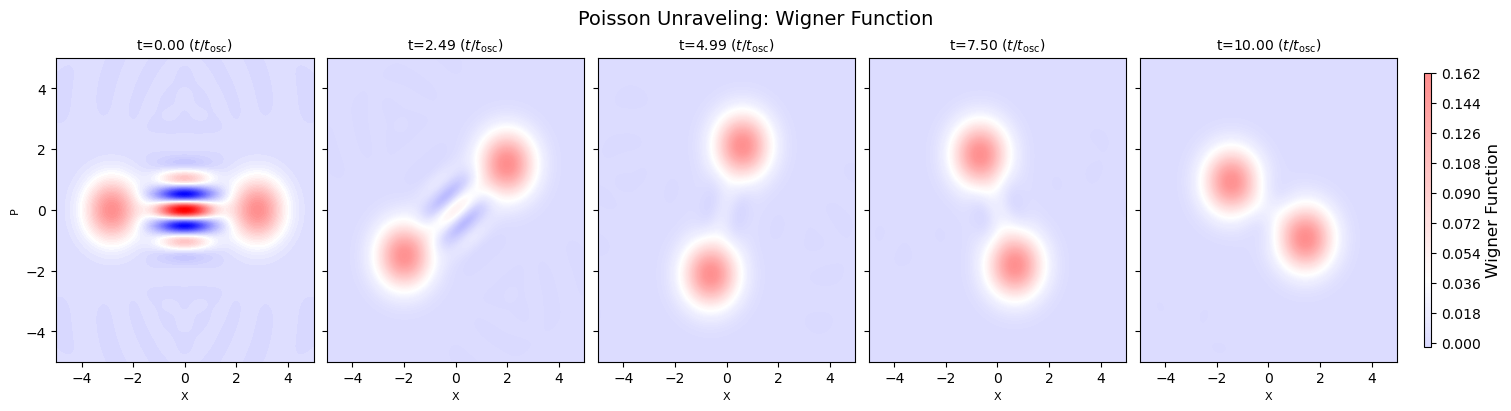

In [5]:
# Function for plotting results
def plot_results(title, ylabel, results, filename):
    plt.figure(figsize=(8, 5))
    for ntraj in poisson_ntraj_list:
        plt.plot(tlist, results[ntraj], label=f"{ylabel} (ntraj={ntraj})")
    plt.xlabel(r"Time $(t/t_{\mathrm{osc}})$")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(img_path, f'{filename}.pdf'), dpi=300)
    plt.show()

# Generate and save plots
plot_results("Parity Evolution (Poisson Unraveling)", "Parity", poisson_parity_results, "parity_evolution_poisson_multi_math599")
plot_results("Photon Count (Poisson Unraveling)", "Photon Count", poisson_photon_results, "photon_count_poisson_multi_math599")
plot_results("Coherence Evolution (Poisson Unraveling)", "Coherence", poisson_coherence_results, "coherence_poisson_multi_math599")

# Function to plot Wigner snapshots
def save_wigner_snapshots(states, title, times, x_range=5, y_range=5, filename="wigner_snapshots"):
    """Efficiently computes and saves Wigner snapshots."""
    
    # Set up phase space grid
    x = np.linspace(-x_range, x_range, 200)
    y = np.linspace(-y_range, y_range, 200)
    X, Y = np.meshgrid(x, y)
    
    # Select 5 evenly spaced snapshots
    snapshot_indices = np.linspace(0, len(states) - 1, 5, dtype=int)

    # Compute all Wigner functions in one pass
    wigner_data = [wigner(states[idx], x, y) for idx in snapshot_indices]
    
    # Find global min and max for color scaling
    global_min = min(W.min() for W in wigner_data)
    global_max = max(W.max() for W in wigner_data)

    # Create the figure and axes with constrained layout
    fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True, constrained_layout=True)

    # Plot each snapshot
    for i, (idx, W) in enumerate(zip(snapshot_indices, wigner_data)):
        ax = axes[i]
        im = ax.contourf(X, Y, W, 100, cmap="bwr", vmin=global_min, vmax=global_max)  # Reduced contour levels
        ax.set_title(rf"t={times[idx]:.2f} $(t/t_{{\mathrm{{osc}}}})$", fontsize=10)
        ax.set_xlabel("X", fontsize=8)
        if i == 0:
            ax.set_ylabel("P", fontsize=8)

    # Add a single color bar for the entire figure
    cbar = fig.colorbar(im, ax=axes, location="right", aspect=40, shrink=0.9, pad=0.02)
    cbar.set_label("Wigner Function", fontsize=12)

    # Save the figure
    fig.suptitle(title, fontsize=14)
    plt.savefig(os.path.join(img_path, f'{filename}.pdf'), format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

# Wigner snapshots for last simulation
last_ntraj = poisson_ntraj_list[-1]
save_wigner_snapshots(
    poisson_results[last_ntraj].states,
    "Poisson Unraveling: Wigner Function",
    tlist,
    filename="poisson_wigner_multi_math599",
)

In [ ]:
# Use the last Monte Carlo result
poisson_final_result = poisson_results[last_ntraj]

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(5, 4))

# Prepare phase space grid
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)

# # Precompute Wigner functions for all frames
# wigner_frames = [wigner(state if not state.isket else state * state.dag(), x, y, parfor=True) for state in poisson_final_result.states]

# Function to compute Wigner function for a given state
def compute_wigner(state):
    state = state if not state.isket else state * state.dag()
    return wigner(state, x, y)

# Use parallel processing to compute Wigner functions
wigner_frames = Parallel(n_jobs=-1)(
    delayed(compute_wigner)(state) for state in tqdm(poisson_final_result.states, desc="Computing Wigner Functions")
)


# Compute global color scale limits (min/max values)
global_min = min(W.min() for W in wigner_frames)
global_max = max(W.max() for W in wigner_frames)

# Initialize plot with the first frame
cax = ax.pcolormesh(X, Y, wigner_frames[0], shading='auto', cmap="bwr", vmin=global_min, vmax=global_max)
ax.set_xlabel("X")
ax.set_ylabel("P")
ax.set_title(rf"(Poisson) Wigner Function at t=0 $(t/t_{{\mathrm{{osc}}}})$")
fig.colorbar(cax, ax=ax)

# Update function for animation
def update(frame):
    cax.set_array(wigner_frames[frame])  # Use precomputed Wigner functions
    ax.set_title(rf"(Poisson) Wigner Function at t={tlist[frame]:.2f} $(t/t_{{\mathrm{{osc}}}})$")
    return [cax]

# Create animation
anim = FuncAnimation(fig, update, frames=len(tlist), blit=False, repeat=False)

# Save animation as GIF
anim.save(os.path.join(img_path, "wigner_animation_poisson_opti646.gif"), writer="pillow", fps=10)
plt.close(fig)


Computing Wigner Functions: 100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s]


## Wiener Unraveling

100%|██████████| 4/4 [08:45<00:00, 131.45s/num_traj]


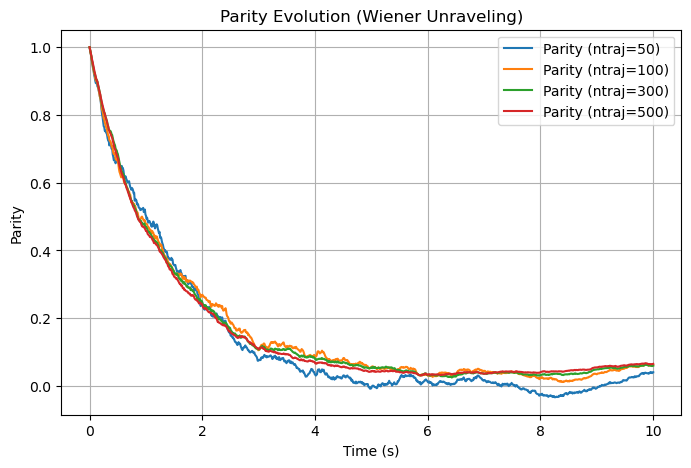

100%|██████████| 4/4 [08:42<00:00, 130.66s/num_traj]


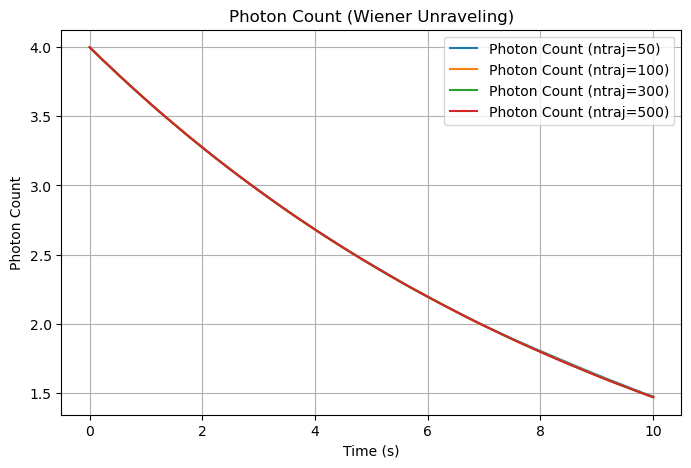

100%|██████████| 4/4 [06:59<00:00, 104.79s/num_traj]


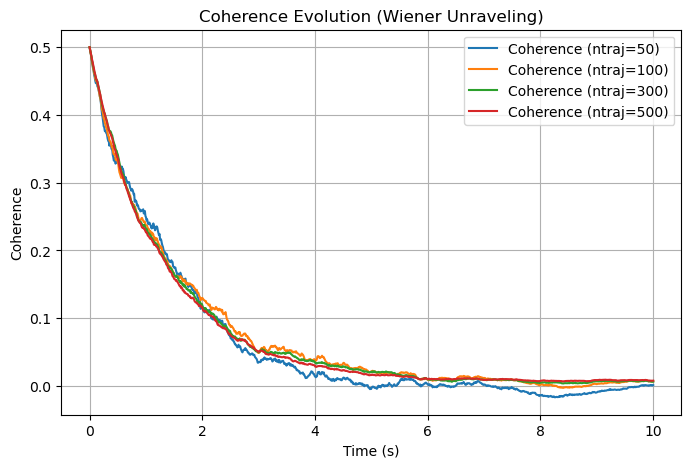

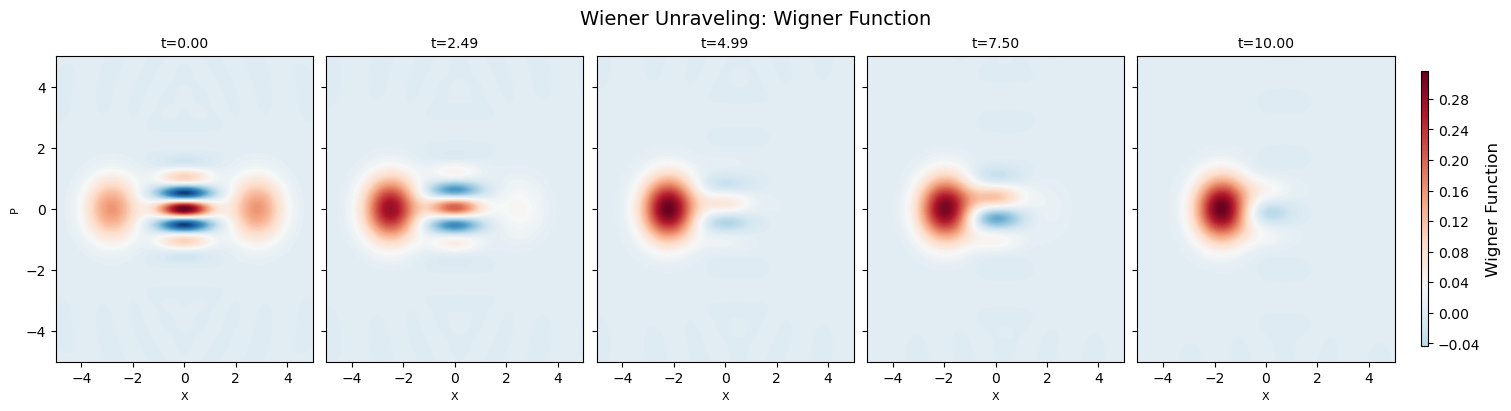

In [ ]:
# Parameters
alpha = 2.0             # Coherent state amplitude
kappa = 0.1             # Photon loss rate
t_max = 10.0             # Maximum simulation time
n_steps = 1000          # Number of time steps
dim = 20                # Hilbert space dimension
dt = t_max / n_steps    # Time step size
tlist = np.linspace(0, t_max, n_steps)
wiener_seed = 42

# Initial cat state
coherent_plus = coherent(dim, alpha) + coherent(dim, -alpha)
psi_cat = coherent_plus.unit()

# Operators
a = destroy(dim)
Delta = 0.00  # Detuning (set to zero if not applicable)
H = Delta * a.dag() * a  # Example Hamiltonian
L1 = np.sqrt(kappa / 2) * (a + 1j * alpha)
L2 = 1j * np.sqrt(kappa / 2) * (a - 1j * alpha)
c_ops = [L1, L2]

# Parity operator
parity_op = sum(
    [(-1) ** n * basis(dim, n) * basis(dim, n).dag() for n in range(dim)]
)

# Photon number operator
photon_number_op = a.dag() * a

# Coherence operator (off-diagonal element between |alpha> and |-alpha>)
coherence_op = coherent(dim, alpha) * coherent(dim, -alpha).dag()

# Different ntraj values to compare
wiener_ntraj_list = [50, 100, 300, 500]
# wiener_ntraj_list = [5, 10, 15]

# Parity Evolution
plt.figure(figsize=(8, 5))

# Run Wiener unraveling simulations and plot parity evolution
for ntraj in tqdm(wiener_ntraj_list, unit='num_traj'):
    wiener_ntraj_parity = np.zeros((ntraj, len(tlist)))

    np.random.seed(wiener_seed)  # For reproducibility
    for traj in tqdm(range(ntraj), unit='traj'):
        state = psi_cat  # Reset state for each trajectory
        trajectory_states = [state]  # Include the initial state

        for t in tlist[:-1]:  # Iterate over all but the last time step
            # Expectation values for the collapse operators
            L1_exp = expect(L1, state)
            L2_exp = expect(L2, state)

            # Wiener increments
            dW1 = np.sqrt(dt) * np.random.randn()
            dW2 = np.sqrt(dt) * np.random.randn()

            # Deterministic evolution term
            deterministic = (
                -1j * H * state * dt
                + (L1_exp.conjugate() * L1 - 0.5 * (L1.dag() * L1 + np.abs(L1_exp)**2)) * state * dt
                + (L2_exp.conjugate() * L2 - 0.5 * (L2.dag() * L2 + np.abs(L2_exp)**2)) * state * dt
            )

            # Stochastic evolution term
            stochastic = (
                (L1 - L1_exp) * state * dW1
                + (L2 - L2_exp) * state * dW2
            )

            # Update state and normalize
            state = (state + deterministic + stochastic).unit()
            trajectory_states.append(state)  # Append the new state

        # Compute parity for this trajectory
        wiener_ntraj_parity[traj] = [
            expect(parity_op, state) for state in trajectory_states
        ]

    # Average over all QSD trajectories
    wiener_parity = np.mean(wiener_ntraj_parity, axis=0)
    plt.plot(tlist, wiener_parity, label=f"Parity (ntraj={ntraj})")

plt.xlabel("Time $(t/t_\\text{{osc}})$")
plt.ylabel("Parity")
plt.title("Parity Evolution (Wiener Unraveling)")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(img_path, 'parity_evolution_wiener_multi_math599.pdf'), dpi=300)

# Show the plot
plt.show()

# Photon Number Evolution
plt.figure(figsize=(8, 5))

# Run Wiener unraveling simulations and plot photon number evolution
for ntraj in tqdm(wiener_ntraj_list, unit='num_traj'):
    wiener_ntraj_photon_number = np.zeros((ntraj, len(tlist)))

    np.random.seed(wiener_seed)  # For reproducibility
    for traj in tqdm(range(ntraj), unit='traj'):
        state = psi_cat  # Reset state for each trajectory
        trajectory_states = [state]  # Include the initial state

        for t in tlist[:-1]:  # Iterate over all but the last time step
            # Expectation values for the collapse operators
            L1_exp = expect(L1, state)
            L2_exp = expect(L2, state)

            # Wiener increments
            dW1 = np.sqrt(dt) * np.random.randn()
            dW2 = np.sqrt(dt) * np.random.randn()

            # Deterministic evolution term
            deterministic = (
                -1j * H * state * dt
                + (L1_exp.conjugate() * L1 - 0.5 * (L1.dag() * L1 + np.abs(L1_exp)**2)) * state * dt
                + (L2_exp.conjugate() * L2 - 0.5 * (L2.dag() * L2 + np.abs(L2_exp)**2)) * state * dt
            )

            # Stochastic evolution term
            stochastic = (
                (L1 - L1_exp) * state * dW1
                + (L2 - L2_exp) * state * dW2
            )

            # Update state and normalize
            state = (state + deterministic + stochastic).unit()
            trajectory_states.append(state)  # Append the new state

        # Compute photon number for this trajectory
        wiener_ntraj_photon_number[traj, :] = [
        expect(photon_number_op, state) for state in trajectory_states
        ]

    # Average over all QSD trajectories
    wiener_photon_number = np.mean(wiener_ntraj_photon_number, axis=0)
    plt.plot(tlist, wiener_photon_number, label=f"Photon Count (ntraj={ntraj})")

plt.xlabel("Time $(t/t_\\text{{osc}})$")
plt.ylabel("Photon Count")
plt.title("Photon Count (Wiener Unraveling)")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(img_path, 'photon_count_wiener_multi_math599.pdf'), dpi=300)

# Show the plot
plt.show()

# Coherence Evolution
plt.figure(figsize=(8, 5))

# Run Wiener unraveling simulations and plot coherence
for ntraj in tqdm(wiener_ntraj_list, unit="num_traj"):
    wiener_ntraj_coherence = np.zeros((ntraj, len(tlist)))

    np.random.seed(wiener_seed)  # For reproducibility
    for traj in tqdm(range(ntraj), unit="traj"):
        state = psi_cat  # Reset state for each trajectory
        trajectory_states = [state]  # Include the initial state

        for t in tlist[:-1]:  # Iterate over all but the last time step
            # Expectation values for the collapse operators
            L1_exp = expect(L1, state)
            L2_exp = expect(L2, state)

            # Wiener increments
            dW1 = np.sqrt(dt) * np.random.randn()
            dW2 = np.sqrt(dt) * np.random.randn()

            # Deterministic evolution term
            deterministic = (
                -1j * H * state * dt
                + (L1_exp.conjugate() * L1 - 0.5 * (L1.dag() * L1 + np.abs(L1_exp)**2)) * state * dt
                + (L2_exp.conjugate() * L2 - 0.5 * (L2.dag() * L2 + np.abs(L2_exp)**2)) * state * dt
            )

            # Stochastic evolution term
            stochastic = (
                (L1 - L1_exp) * state * dW1
                + (L2 - L2_exp) * state * dW2
            )

            # Update state and normalize
            state = (state + deterministic + stochastic).unit()
            trajectory_states.append(state)  # Append the new state

        # Compute coherence for this trajectory
        wiener_ntraj_coherence[traj, :] = [
        np.real(state.overlap(coherence_op)) for state in trajectory_states
        ]

    # Average over all QSD trajectories
    wiener_coherence = np.mean(wiener_ntraj_coherence, axis=0)
    plt.plot(tlist, wiener_coherence, label=f"Coherence (ntraj={ntraj})")

plt.xlabel("Time $(t/t_\\text{{osc}})$")
plt.ylabel("Coherence")
plt.title("Coherence Evolution (Wiener Unraveling)")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(img_path, 'coherence_wiener_multi_math599.pdf'), dpi=300)

# Show the plot
plt.show()

# Function to plot Wigner snapshots
def save_wigner_snapshots(
    states, title, times, n_steps, x_range=5, y_range=5, filename="wigner_snapshots"
):
    x = np.linspace(-x_range, x_range, 200)
    y = np.linspace(-y_range, y_range, 200)
    X, Y = np.meshgrid(x, y)

    # Compute global min and max across all states for consistent color scale
    global_min, global_max = float("inf"), float("-inf")
    for state in states:
        W = wigner(state, x, y)
        global_min = min(global_min, W.min())
        global_max = max(global_max, W.max())

    # Select 5 evenly spaced snapshots
    snapshot_indices = np.linspace(0, len(states) - 1, 5, dtype=int)

    # Create the figure and axes with constrained layout
    fig, axes = plt.subplots(
        1, 5, figsize=(15, 4), sharey=True, constrained_layout=True
    )

    # Plot each snapshot
    for i, idx in enumerate(snapshot_indices):
        state = states[idx]
        W = wigner(state, x, y)
        ax = axes[i]
        im = ax.contourf(
            X, Y, W, 100, cmap="RdBu_r", vmin=global_min, vmax=global_max
        )
        ax.set_title(f"t={times[idx]:.2f} $(t/t_\\text{{osc}})$", fontsize=10)
        ax.set_xlabel("X", fontsize=8)
        if i == 0:
            ax.set_ylabel("P", fontsize=8)

    # Add a single color bar for the entire figure
    cbar = fig.colorbar(
        im, ax=axes, location="right", aspect=40, shrink=0.9, pad=0.02
    )
    cbar.set_label("Wigner Function", fontsize=12)

    # Save the figure in tight layout
    fig.suptitle(title, fontsize=14)
    plt.savefig(os.path.join(img_path, f'{filename}.pdf'), format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

# Wigner snapshots
wiener_states = [psi_cat]
state = psi_cat
np.random.seed(wiener_seed)  # For reproducibility

for t in tlist[:-1]:
    # Expectation values
    L1_exp = expect(L1, state)
    L2_exp = expect(L2, state)

    # Wiener increments
    dW1 = np.sqrt(dt) * np.random.randn()
    dW2 = np.sqrt(dt) * np.random.randn()

    # Deterministic evolution term
    deterministic = (
        -1j * H * state * dt
        + (L1_exp.conjugate() * L1 - 0.5 * (L1.dag() * L1 + np.abs(L1_exp)**2)) * state * dt
        + (L2_exp.conjugate() * L2 - 0.5 * (L2.dag() * L2 + np.abs(L2_exp)**2)) * state * dt
    )

    # Stochastic evolution term
    stochastic = (
        1 / np.sqrt(2) * ((L1 - L1_exp) * state * dW1
        + (L2 - L2_exp) * state * dW2)
    )

    # Update state and normalize
    state = (state + deterministic + stochastic).unit()
    wiener_states.append(state)
    
# Save Poisson unraveling snapshots
save_wigner_snapshots(
    wiener_states,
    "Wiener Unraveling: Wigner Function",
    tlist,
    n_steps,
    filename="wiener_wigner_multi_math599",
)


In [8]:
# Set parameters
alpha = 2.0
kappa = 0.1
t_max = 10.0
n_steps = 1000
dim = 20
dt = t_max / n_steps
tlist = np.linspace(0, t_max, n_steps)
wiener_seed = 42

# Operators
a = destroy(dim)
Delta = 1.00
H = Delta * a.dag() * a
L1 = np.sqrt(kappa / 2) * (a + 1j * alpha)
L2 = 1j * np.sqrt(kappa / 2) * (a - 1j * alpha)
c_ops = [L1, L2]

# Observables
parity_op = sum([(-1) ** n * basis(dim, n) * basis(dim, n).dag() for n in range(dim)])
photon_number_op = a.dag() * a
coherence_op = coherent(dim, alpha) * coherent(dim, -alpha).dag()

# Different ntraj values
wiener_ntraj_list = [50, 100, 300, 500]

# Initial cat state (stored once)
psi_cat = (coherent(dim, alpha) + coherent(dim, -alpha)).unit()

# Set random seed once
np.random.seed(wiener_seed)

# Function to evolve a single quantum trajectory
def evolve_trajectory():
    state = psi_cat
    states = [state]

    for t in tlist[:-1]:
        # Compute expectation values
        L1_exp = expect(L1, state)
        L2_exp = expect(L2, state)

        # Wiener increments
        dW1, dW2 = np.sqrt(dt) * np.random.randn(2)

        # Deterministic evolution
        deterministic = (
            -1j * H * state * dt
            + (L1_exp.conjugate() * L1 - 0.5 * (L1.dag() * L1 + np.abs(L1_exp) ** 2)) * state * dt
            + (L2_exp.conjugate() * L2 - 0.5 * (L2.dag() * L2 + np.abs(L2_exp) ** 2)) * state * dt
        )

        # Stochastic evolution
        stochastic = ((L1 - L1_exp) * state * dW1 + (L2 - L2_exp) * state * dW2)

        # Update state and normalize
        state = (state + deterministic + stochastic).unit()
        states.append(state)

    return states

# Function to run simulations and compute expectation values
def compute_expectations(ntraj):
    traj_states = np.array([evolve_trajectory() for _ in tqdm(range(ntraj), unit="traj")])

    parity_values = np.mean([[expect(parity_op, state) for state in traj] for traj in traj_states], axis=0)
    photon_number_values = np.mean([[expect(photon_number_op, state) for state in traj] for traj in traj_states], axis=0)
    coherence_values = np.mean([[np.real(state.overlap(coherence_op)) for state in traj] for traj in traj_states], axis=0)

    return parity_values, photon_number_values, coherence_values

# Run Wiener unraveling for different `ntraj` values
parity_results, photon_results, coherence_results = {}, {}, {}

for ntraj in tqdm(wiener_ntraj_list, unit="num_traj"):
    parity_values, photon_number_values, coherence_values = compute_expectations(ntraj)

    # Store results
    parity_results[ntraj] = parity_values
    photon_results[ntraj] = photon_number_values
    coherence_results[ntraj] = coherence_values
    



  0%|          | 0/4 [00:00<?, ?num_traj/s]




















































 25%|██▌       | 1/4 [00:30<01:30, 30.13s/num_traj]






















 32%|███▏      | 95/300 [02:00<04:19,  1.27s/traj]


KeyboardInterrupt: 

In [ ]:
# Set parameters (unchanged)
alpha = 2.0
kappa = 0.1
t_max = 10.0
n_steps = 1000
dim = 20
dt = t_max / n_steps
tlist = np.linspace(0, t_max, n_steps)
wiener_seed = 42

# Operators
a = destroy(dim)
Delta = 0.00
H = Delta * a.dag() * a
L1 = np.sqrt(kappa / 2) * (a + 1j * alpha)
L2 = 1j * np.sqrt(kappa / 2) * (a - 1j * alpha)
c_ops = [L1, L2]

# Observables
parity_op = sum([(-1) ** n * basis(dim, n) * basis(dim, n).dag() for n in range(dim)])
photon_number_op = a.dag() * a
coherence_op = coherent(dim, alpha) * coherent(dim, -alpha).dag()

# Different ntraj values
wiener_ntraj_list = [50, 100, 300, 500]
# wiener_ntraj_list = [5]

# Initial cat state (stored once)
psi_cat = (coherent(dim, alpha) + coherent(dim, -alpha)).unit()

# # Set random seed once
# np.random.seed(wiener_seed)

# Function to evolve a single quantum trajectory
def evolve_trajectory(seed=wiener_seed):
    """Evolves a single trajectory and returns the state evolution."""
    np.random.seed(seed)  # Ensure reproducibility for each trajectory
    state = psi_cat
    states = [state]

    for t in tlist[:-1]:  
        # Compute expectation values
        L1_exp = expect(L1, state)
        L2_exp = expect(L2, state)

        # Wiener increments
        dW1, dW2 = np.sqrt(dt) * np.random.randn(2)

        # Deterministic evolution
        deterministic = (
            -1j * H * state * dt
            + (L1_exp.conjugate() * L1 - 0.5 * (L1.dag() * L1 + np.abs(L1_exp) ** 2)) * state * dt
            + (L2_exp.conjugate() * L2 - 0.5 * (L2.dag() * L2 + np.abs(L2_exp) ** 2)) * state * dt
        )

        # Stochastic evolution
        stochastic = ((L1 - L1_exp) * state * dW1 + (L2 - L2_exp) * state * dW2)

        # Update state and normalize
        state = (state + deterministic + stochastic).unit()
        states.append(state)

    return states


# Compute expectation values in parallel
def compute_expectations(ntraj):
    """Evolves ntraj trajectories and computes expectation values in parallel."""
    
    # Generate unique seeds for each trajectory to ensure independent randomness
    seeds = np.random.randint(0, 1e6, size=ntraj)

    # Run trajectories in parallel
    traj_states = Parallel(n_jobs=-1)(
        delayed(evolve_trajectory)(seed) for seed in tqdm(seeds, unit="traj")
    )

    # Compute expectation values efficiently
    parity_values = np.mean([[expect(parity_op, state) for state in traj] for traj in traj_states], axis=0)
    photon_number_values = np.mean([[expect(photon_number_op, state) for state in traj] for traj in traj_states], axis=0)
    coherence_values = np.mean([[np.real(state.overlap(coherence_op)) for state in traj] for traj in traj_states], axis=0)

    return parity_values, photon_number_values, coherence_values


# Run Wiener unraveling for different `ntraj` values
parity_results, photon_results, coherence_results = {}, {}, {}

for ntraj in tqdm(wiener_ntraj_list, unit="num_traj"):
    parity_values, photon_number_values, coherence_values = compute_expectations(ntraj)

    # Store results
    parity_results[ntraj] = parity_values
    photon_results[ntraj] = photon_number_values
    coherence_results[ntraj] = coherence_values

100%|██████████| 4/4 [03:51<00:00, 57.94s/num_traj]


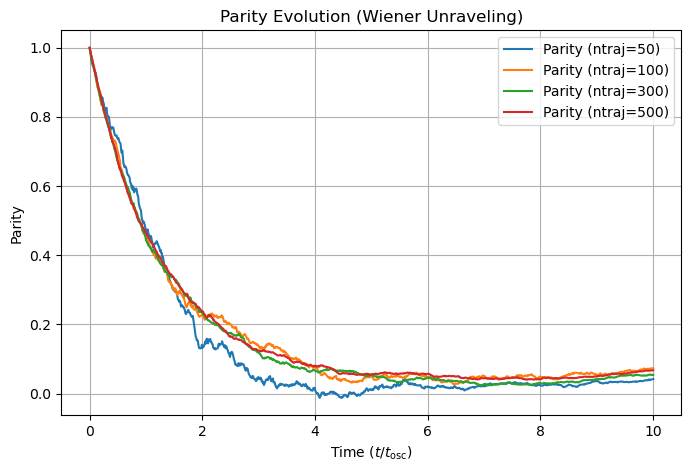

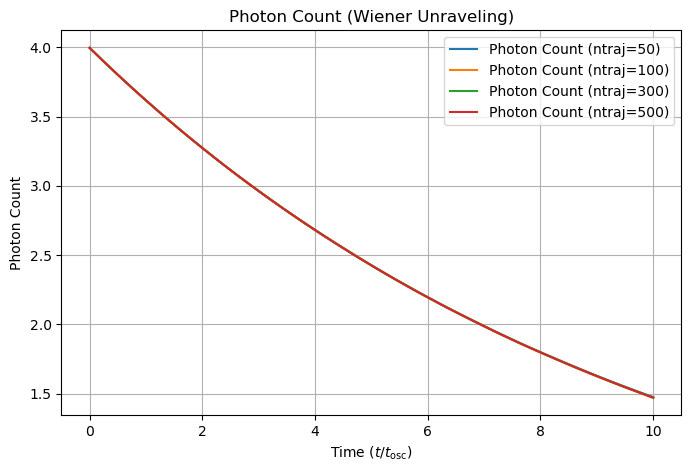

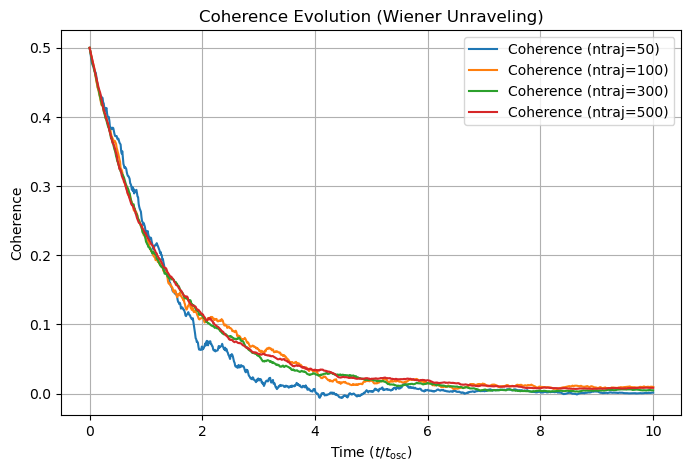

TypeError: evolve_trajectory() missing 1 required positional argument: 'seed'

In [39]:
# Function to plot results
def plot_results(title, ylabel, results_dict, filename):
    plt.figure(figsize=(8, 5))
    for ntraj, values in results_dict.items():
        plt.plot(tlist, values, label=f"{ylabel} (ntraj={ntraj})")
    plt.xlabel(r"Time $(t/t_{\mathrm{osc}})$")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(img_path, f"{filename}.pdf"), dpi=300)
    plt.show()

# Plot results
plot_results("Parity Evolution (Wiener Unraveling)", "Parity", parity_results, "parity_evolution_wiener_multi_math599")
plot_results("Photon Count (Wiener Unraveling)", "Photon Count", photon_results, "photon_count_wiener_multi_math599")
plot_results("Coherence Evolution (Wiener Unraveling)", "Coherence", coherence_results, "coherence_wiener_multi_math599")

# Function to plot Wigner snapshots
def save_wigner_snapshots(
    states, title, times, n_steps, x_range=5, y_range=5, filename="wigner_snapshots"
):
    """
    Optimized function for computing and plotting Wigner snapshots while
    ensuring the correct global color scaling and contour rendering.
    """
    # Define phase-space grid
    x = np.linspace(-x_range, x_range, 200)
    y = np.linspace(-y_range, y_range, 200)
    X, Y = np.meshgrid(x, y)

    # Compute Wigner functions for all states to determine global min/max
    wigner_values = Parallel(n_jobs=-1)(
        delayed(wigner)(state, x, y) for state in states
    )

    # Compute global color scale limits
    global_min = min(W.min() for W in wigner_values)
    global_max = max(W.max() for W in wigner_values)

    # Select 5 evenly spaced snapshots
    snapshot_indices = np.linspace(0, len(states) - 1, 5, dtype=int)

    # Create figure and subplots
    fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True, constrained_layout=True)

    # Plot each snapshot using contourf
    for i, idx in enumerate(snapshot_indices):
        state = states[idx]
        W = wigner_values[idx]  # Use precomputed Wigner function
        ax = axes[i]
        im = ax.contourf(X, Y, W, 100, cmap="RdBu_r", vmin=global_min, vmax=global_max)
        ax.set_title(rf"t={times[idx]:.2f}", fontsize=10)
        ax.set_xlabel("X", fontsize=8)
        if i == 0:
            ax.set_ylabel("P", fontsize=8)

    # Add a single color bar for all subplots
    cbar = fig.colorbar(im, ax=axes, location="right", aspect=40, shrink=0.9, pad=0.02)
    cbar.set_label("Wigner Function", fontsize=12)

    # Save the figure
    fig.suptitle(title, fontsize=14)
    plt.savefig(os.path.join(img_path, f'{filename}.pdf'), format="pdf", bbox_inches="tight", dpi=300)
    plt.show()
    
# Wigner snapshots
wiener_states = evolve_trajectory()
save_wigner_snapshots(
    wiener_states,
    "Wiener Unraveling: Wigner Function",
    tlist,
    n_steps,
    filename="wiener_wigner_multi_math599",
)

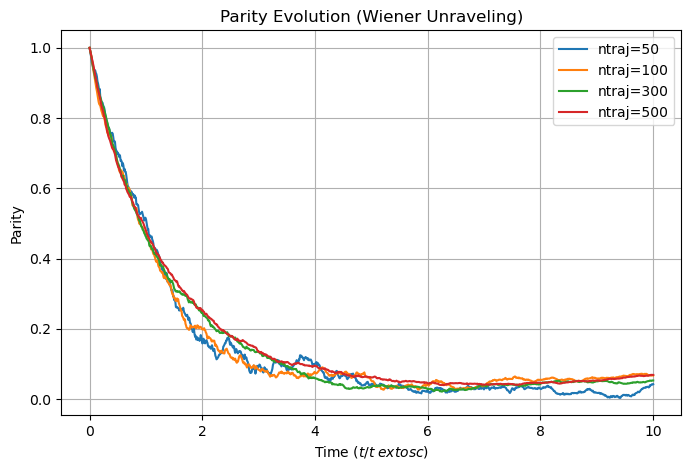

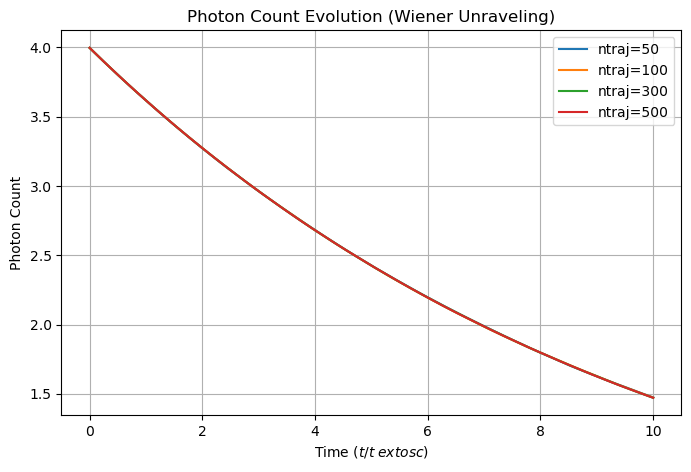

/Users/EricSung/opt/anaconda3/envs/open_quantum_systems_env/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/EricSung/opt/anaconda3/envs/open_quantum_systems_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


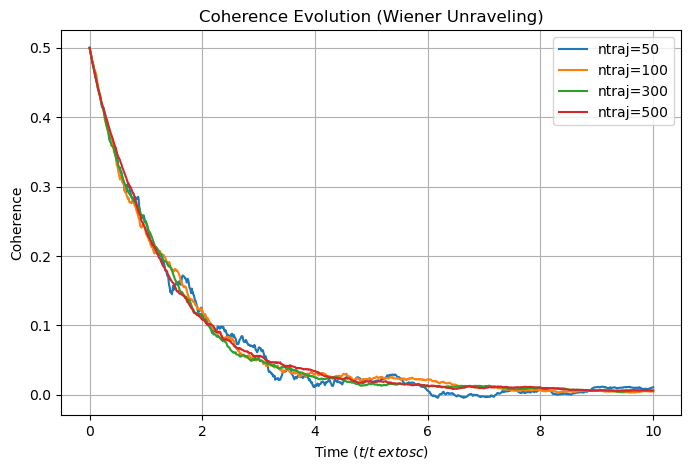

In [ ]:
# Parameters
alpha, kappa, t_max, n_steps, dim = 2.0, 0.1, 10.0, 1000, 20
dt, tlist, wiener_seed = t_max / n_steps, np.linspace(0, t_max, n_steps), 42

# Initial cat state
psi_cat = (coherent(dim, alpha) + coherent(dim, -alpha)).unit()

# Operators
a, L1, L2 = destroy(dim), np.sqrt(kappa / 2) * (destroy(dim) + 1j * alpha), 1j * np.sqrt(kappa / 2) * (destroy(dim) - 1j * alpha)
c_ops = [L1, L2]

# Observables
parity_op = sum([(-1) ** n * basis(dim, n) * basis(dim, n).dag() for n in range(dim)])
photon_number_op = a.dag() * a
coherence_op = coherent(dim, alpha) * coherent(dim, -alpha).dag()
wiener_ntraj_list = [50, 100, 300, 500]

# Function to simulate a single trajectory
def simulate_trajectory(observable):
    state, trajectory_states = psi_cat, [psi_cat]
    
    for _ in range(len(tlist) - 1):
        L1_exp, L2_exp = expect(L1, state), expect(L2, state)
        dW1, dW2 = np.sqrt(dt) * np.random.randn(), np.sqrt(dt) * np.random.randn()
        
        deterministic = (-0.5 * (L1.dag() * L1 + np.abs(L1_exp) ** 2) + L1_exp.conjugate() * L1) * state * dt
        deterministic += (-0.5 * (L2.dag() * L2 + np.abs(L2_exp) ** 2) + L2_exp.conjugate() * L2) * state * dt
        
        state = (state + deterministic + (L1 - L1_exp) * state * dW1 + (L2 - L2_exp) * state * dW2).unit()
        trajectory_states.append(state)
    
    return np.array(expect(observable, trajectory_states))

# Parallelized Wiener unraveling
def run_wiener_unraveling(ntraj, observable):
    np.random.seed(wiener_seed)
    results = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(observable) for _ in range(ntraj))
    return np.mean(results, axis=0)

# Optimized plotting function
def plot_evolution(observable, ylabel, filename):
    plt.figure(figsize=(8, 5))
    for ntraj in wiener_ntraj_list:
        plt.plot(tlist, run_wiener_unraveling(ntraj, observable), label=f"ntraj={ntraj}")
    plt.xlabel("Time $(t/t_\text{osc})$")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} Evolution (Wiener Unraveling)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(img_path, f'{filename}.pdf'), dpi=300)
    plt.show()

# Run and plot simulations
plot_evolution(parity_op, "Parity", "parity_evolution_wiener_multi_math599")
plot_evolution(photon_number_op, "Photon Count", "photon_count_wiener_multi_math599")
plot_evolution(coherence_op, "Coherence", "coherence_wiener_multi_math599")


## Comparison 

In [ ]:

# Parameters
alpha = 2.0             # Coherent state amplitude
kappa = 0.1             # Photon loss rate
t_max = 10.0             # Maximum simulation time
n_steps = 1000          # Number of time steps
dim = 20                # Hilbert space dimension
dt = t_max / n_steps    # Time step size
tlist = np.linspace(0, t_max, n_steps)
poisson_seed = 42

# Initial cat state
coherent_plus = coherent(dim, alpha) + coherent(dim, -alpha)
psi_cat = coherent_plus.unit()

# Operators
a = destroy(dim)
Delta = 0.00  # Detuning (set to zero if not applicable)
H = Delta * a.dag() * a  # Example Hamiltonian
L1 = np.sqrt(kappa / 2) * (a + 1j * alpha)
L2 = 1j * np.sqrt(kappa / 2) * (a - 1j * alpha)
c_ops = [L1, L2]

# Parity operator
parity_op = sum(
    [(-1) ** n * basis(dim, n) * basis(dim, n).dag() for n in range(dim)]
)

# Photon number operator
photon_number_op = a.dag() * a

# Coherence operator (off-diagonal element between |alpha> and |-alpha>)
coherence_op = coherent(dim, alpha) * coherent(dim, -alpha).dag()

# Different ntraj values to compare
ntraj_list_comp = 500

# ------------------------------
# Poisson Unraveling (mcsolve)
# ------------------------------
poisson_result_comp = mcsolve(
    H,  # Corrected Hamiltonian
    psi_cat,
    tlist,
    c_ops=c_ops,
    ntraj=ntraj_list_comp,
    seeds=poisson_seed
)

poisson_parity_comp = expect(parity_op, poisson_result_comp.states)
poisson_photon_number_comp = expect(photon_number_op, poisson_result_comp.states)
poisson_coherence_comp = [
    np.real(state.overlap(coherence_op)) for state in poisson_result_comp.states
]

# ------------------------------
# Quantum State Diffusion (QSD)
# ------------------------------
qsd_trajectory_parity_comp = np.zeros((ntraj_list_comp, len(tlist)))
qsd_trajectory_photon_number_comp = np.zeros((ntraj_list_comp, len(tlist)))
qsd_trajectory_coherence_comp = np.zeros((ntraj_list_comp, len(tlist)))

np.random.seed(42)  # For reproducibility
for traj in tqdm(range(ntraj_list_comp), unit='traj'):
    state = psi_cat  # Reset state for each trajectory
    trajectory_states_comp = [state]  # Include the initial state

    for t in tlist[:-1]:  # Iterate over all but the last time step
        # Expectation values for the collapse operators
        L1_exp = expect(L1, state)
        L2_exp = expect(L2, state)

        # Wiener increments
        dW1 = np.sqrt(dt) * np.random.randn()
        dW2 = np.sqrt(dt) * np.random.randn()

        # Deterministic evolution term
        deterministic = (
            -1j * H * state * dt
            + (L1_exp.conjugate() * L1 - 0.5 * (L1.dag() * L1 + np.abs(L1_exp)**2)) * state * dt
            + (L2_exp.conjugate() * L2 - 0.5 * (L2.dag() * L2 + np.abs(L2_exp)**2)) * state * dt
        )

        # Stochastic evolution term
        stochastic = (
            (L1 - L1_exp) * state * dW1
            + (L2 - L2_exp) * state * dW2
        )

        # Update state and normalize
        state = (state + deterministic + stochastic).unit()
        trajectory_states_comp.append(state)  # Append the new state

    # Compute parity for this trajectory
    qsd_trajectory_parity_comp[traj] = [
        expect(parity_op, state) for state in trajectory_states_comp
    ]
    qsd_trajectory_photon_number_comp[traj, :] = [
        expect(photon_number_op, state) for state in trajectory_states_comp
    ]
    qsd_trajectory_coherence_comp[traj, :] = [
        np.real(state.overlap(coherence_op)) for state in trajectory_states_comp
    ]

# Average over all QSD trajectories
qsd_parity_comp = np.mean(qsd_trajectory_parity_comp, axis=0)
qsd_photon_number_comp = np.mean(qsd_trajectory_photon_number_comp, axis=0)
qsd_coherence_comp = np.mean(qsd_trajectory_coherence_comp, axis=0)

# ------------------------------
# Lindblad Master Equation (mesolve)
# ------------------------------
lindblad_result_comp = mesolve(
    H,  # Corrected Hamiltonian
    psi_cat,
    tlist,
    c_ops=c_ops,
)

lindblad_parity_comp = [
    expect(parity_op, rho) for rho in lindblad_result_comp.states
    ]
lindblad_photon_number_comp = [
    expect(photon_number_op, rho) for rho in lindblad_result_comp.states
]
lindblad_coherence_comp = [
    np.real(rho.overlap(coherence_op)) for rho in lindblad_result_comp.states
]




10.0%. Run time:  11.68s. Est. time left: 00:00:01:45
20.0%. Run time:  21.31s. Est. time left: 00:00:01:25
30.0%. Run time:  31.61s. Est. time left: 00:00:01:13
40.0%. Run time:  40.69s. Est. time left: 00:00:01:01
50.0%. Run time:  47.72s. Est. time left: 00:00:00:47
60.0%. Run time:  54.77s. Est. time left: 00:00:00:36
70.0%. Run time:  61.79s. Est. time left: 00:00:00:26
80.0%. Run time:  68.87s. Est. time left: 00:00:00:17
90.0%. Run time:  75.57s. Est. time left: 00:00:00:08
100.0%. Run time:  82.76s. Est. time left: 00:00:00:00
Total run time:  82.92s


100%|██████████| 500/500 [03:43<00:00,  2.24traj/s]


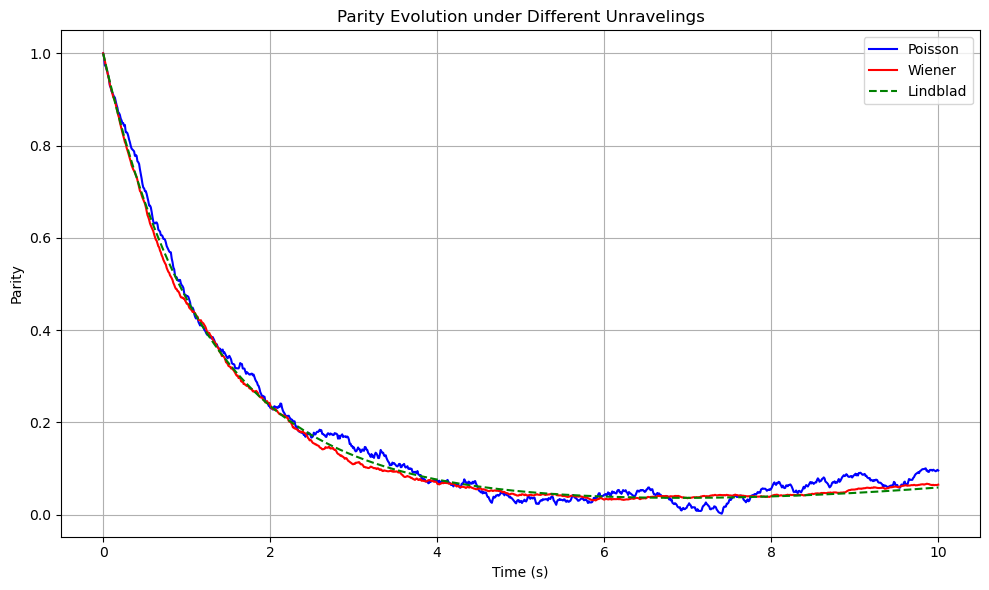

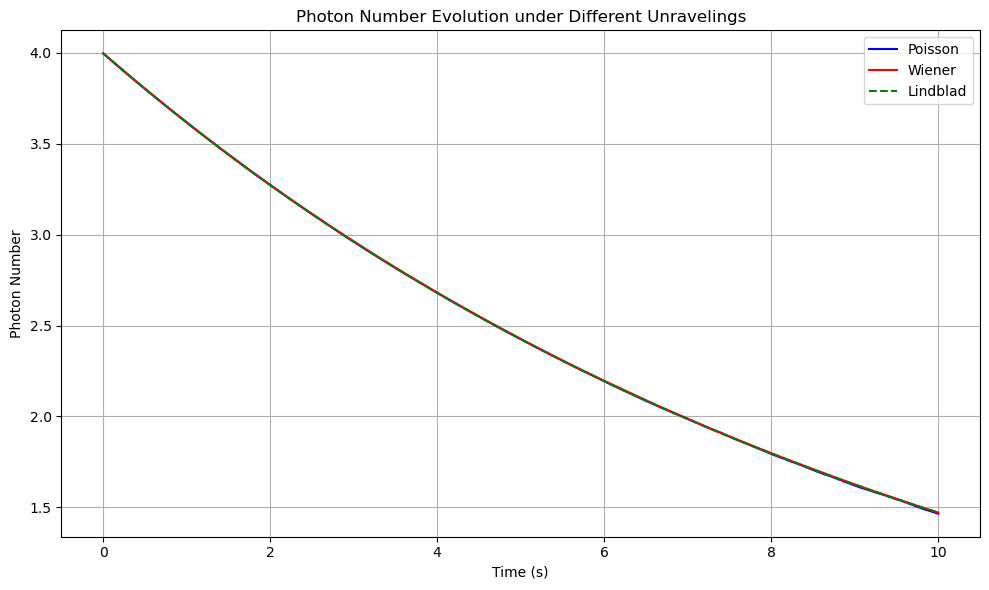

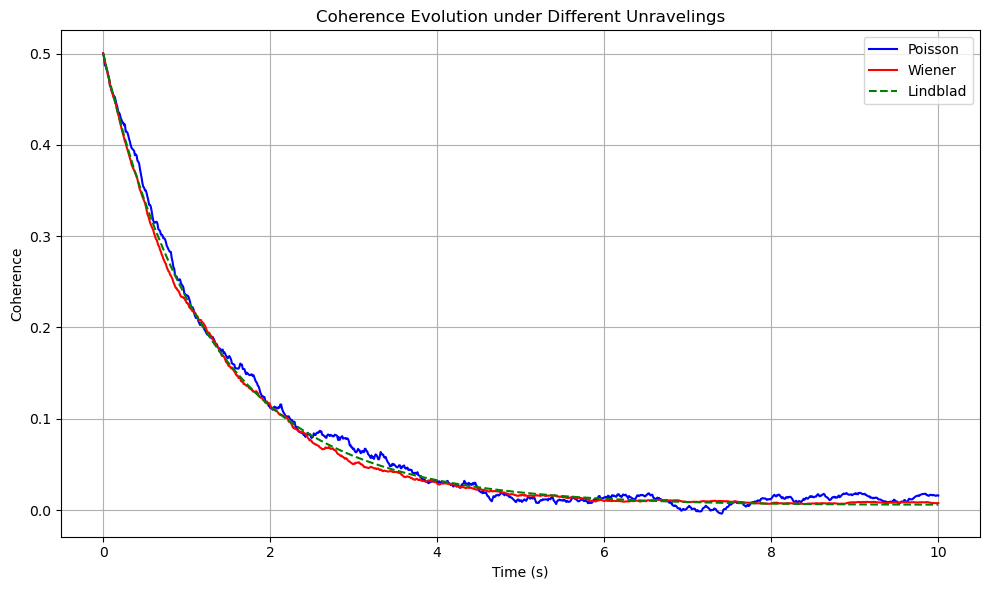

In [53]:
# ------------------------------
# Plot Results
# ------------------------------

# Plot Parity
plt.figure(figsize=(10, 6))
plt.plot(tlist, poisson_parity_comp, label="Poisson", color='blue')
plt.plot(tlist, qsd_parity_comp, label="Wiener", color='red')
plt.plot(tlist, lindblad_parity_comp, label="Lindblad", linestyle="--", color='green')
plt.title("Parity Evolution under Different Unravelings")
plt.xlabel("Time (s)")
plt.ylabel("Parity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(img_path, 'parity_evolution_all.pdf'), dpi=300)
plt.show()

# Plot Photon Number
plt.figure(figsize=(10, 6))
plt.plot(tlist, poisson_photon_number_comp, label="Poisson", color='blue')
plt.plot(tlist, qsd_photon_number_comp, label="Wiener", color='red')
plt.plot(tlist, lindblad_photon_number_comp, label="Lindblad", linestyle="--", color='green')
plt.title("Photon Number Evolution under Different Unravelings")
plt.xlabel("Time (s)")
plt.ylabel("Photon Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(img_path, 'photon_number_all.pdf'), dpi=300)
plt.show()

# Plot Coherence
plt.figure(figsize=(10, 6))
plt.plot(tlist, poisson_coherence_comp, label="Poisson", color='blue')
plt.plot(tlist, qsd_coherence_comp, label="Wiener", color='red')
plt.plot(tlist, lindblad_coherence_comp, label="Lindblad", linestyle="--", color='green')
plt.title("Coherence Evolution under Different Unravelings")
plt.xlabel("Time (s)")
plt.ylabel("Coherence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(img_path, 'coherence_evolution_all.pdf'), dpi=300)
plt.show()